# A Classification Model To Predict Churn Rate of Customers







### BUSINESS UNDERSTANDING

#### **Project Goal**: The aim of the project is to build a classification model that will analyze the data and determine the churn rate of customers.

#### Null Hypothesis: Customers with longer tenures are less likely to churn depending on monthly and total charge.
#### Alternate Hypothesis: Customers with longer tenures are more likely to churn depending on monthly and total charge.

#### Analytical Questions
1. Do customers with higher monthly charges exhibit different churn behaviors compared to those with lower charges?
2. Does payment method affect tenure for customers?
3. Which type of internetservices(DSL,Fiber optics) incur higher monthly charges?
4. What are the total charges by gender? Is there a significant difference between the total charges between males and females.
5. Do dependents cause a rise in monthly charges prompting the possibility of customers churning?


### Data Understanding

#### Import Libraries

In [2]:
import pyodbc 
from dotenv import dotenv_values
import pandas as pd 
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import sqlalchemy 
import warnings 
import numpy as np
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from functools import partial
import os


import joblib


from warnings import filterwarnings
filterwarnings('ignore')



In [3]:
# load the environment variables from the env file into a dictionary
environment_variables=dotenv_values('.env')

# Get the values for the credentials set up in the .env file
database=environment_variables.get('database_name')
server=environment_variables.get('server_name')
username=environment_variables.get('login')
password=environment_variables.get('password')

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"
connection= pyodbc.connect(connection_string)

#### Load Dataset

In [4]:
# Display the table in the data
query= "SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE= 'BASE TABLE'"
data = pd.read_sql(query,connection)
data

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,dapDB,dbo,LP2_Telco_churn_first_3000,BASE TABLE


In [5]:
# Obtaining the datasets
query= 'select * from LP2_Telco_churn_first_3000'
df_1= pd.read_sql(query,connection)
df_1

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2209-XADXF,Female,False,False,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,False,Bank transfer (automatic),25.250000,25.250000,False
2996,6620-JDYNW,Female,False,False,False,18,True,True,DSL,True,...,True,False,False,False,Month-to-month,True,Mailed check,60.599998,1156.349976,False
2997,1891-FZYSA,Male,True,True,False,69,True,True,Fiber optic,False,...,False,False,True,False,Month-to-month,True,Electronic check,89.949997,6143.149902,True
2998,4770-UEZOX,Male,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,74.750000,144.800003,False


In [6]:
# Load the other datasets
df_2= pd.read_csv(r"C:\Users\user\Documents\New folder\LP.2\LP2_Telco-churn-second-2000.csv")
df_2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [7]:
df_test= pd.read_excel(r"C:\Users\user\Documents\New folder\LP.2\Telco-churn-last-2000.xlsx")
df_test.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [8]:
# Concatenate the data
df= pd.concat([df_1, df_2], axis= 0)
df.shape

(5043, 21)

In [9]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [10]:
# save the dataframe df to a csv file 

df.to_csv('churn_analysis.csv')

#### Expolatory Data Analysis

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 
 17  

In [12]:
df.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [13]:
df.duplicated().sum()

0

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.0,0.000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002


In [15]:
# changing to appropriate data types
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') # for the sake of missing values that will considered as empty strings

In [16]:
# loop through columns in training data
for column in df.columns:

    #check if the column is not a numerical column
    if (df[column].dtype not in ['int64', 'float64']):

        # print out unique values in categorical columns
        print(f'column: {column}\nunique values: {df[column].unique()}')
        print(70 * '-')

column: customerID
unique values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
----------------------------------------------------------------------
column: gender
unique values: ['Female' 'Male']
----------------------------------------------------------------------
column: SeniorCitizen
unique values: [0 1]
----------------------------------------------------------------------
column: Partner
unique values: [True False 'No' 'Yes']
----------------------------------------------------------------------
column: Dependents
unique values: [False True 'No' 'Yes']
----------------------------------------------------------------------
column: PhoneService
unique values: [False True 'Yes' 'No']
----------------------------------------------------------------------
column: MultipleLines
unique values: [None False True 'No' 'No phone service' 'Yes']
----------------------------------------------------------------------
column: InternetService
unique valu

A lot of the categorical columns contain values boolean values(True, False) and 'Yes' and 'No' values which are the same meaning as the boolean values. To solve this issue, we either change the boolean values to 'Yes' and 'No', or the other way round

In [17]:
columns_to_change = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup','DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies', 'Churn', 'PaperlessBilling']
for column in columns_to_change:    
    df[column].replace({True: 'Yes', False: 'No', 'No internet service': 'No', 'No phone service': 'No', None: np.nan}, inplace=True)

In [18]:
# loop through columns in training data
for column in df.columns:

    #check if the column is not a numerical column
    if (df[column].dtype not in ['int64', 'float64']):

        # print out unique values in categorical columns
        print(f'column: {column}\nunique values: {df[column].unique()}')
        print(70 * '-')

column: customerID
unique values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
----------------------------------------------------------------------
column: gender
unique values: ['Female' 'Male']
----------------------------------------------------------------------
column: SeniorCitizen
unique values: [0 1]
----------------------------------------------------------------------
column: Partner
unique values: ['Yes' 'No']
----------------------------------------------------------------------
column: Dependents
unique values: ['No' 'Yes']
----------------------------------------------------------------------
column: PhoneService
unique values: ['No' 'Yes']
----------------------------------------------------------------------
column: MultipleLines
unique values: [nan 'No' 'Yes']
----------------------------------------------------------------------
column: InternetService
unique values: ['DSL' 'Fiber optic' 'No']
---------------------------------

#### Univariate Analysis

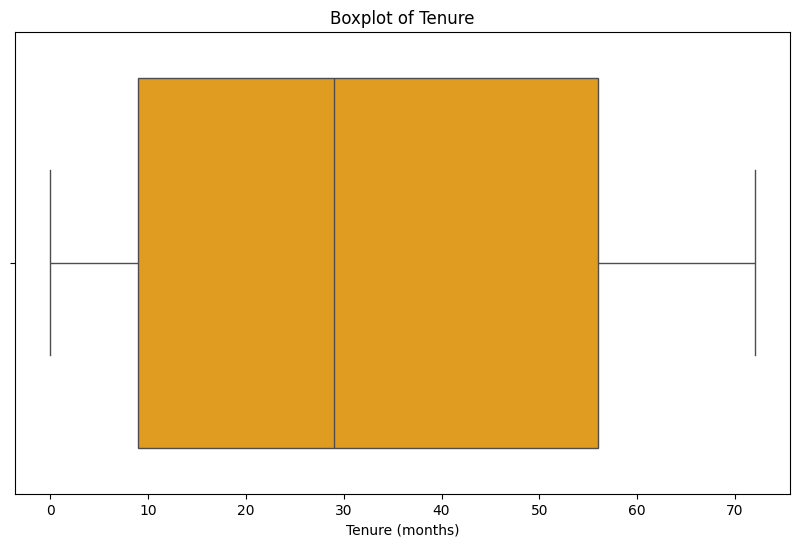

In [19]:
# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='tenure', data=df, color='orange')
plt.title('Boxplot of Tenure')
plt.xlabel('Tenure (months)')
plt.show()


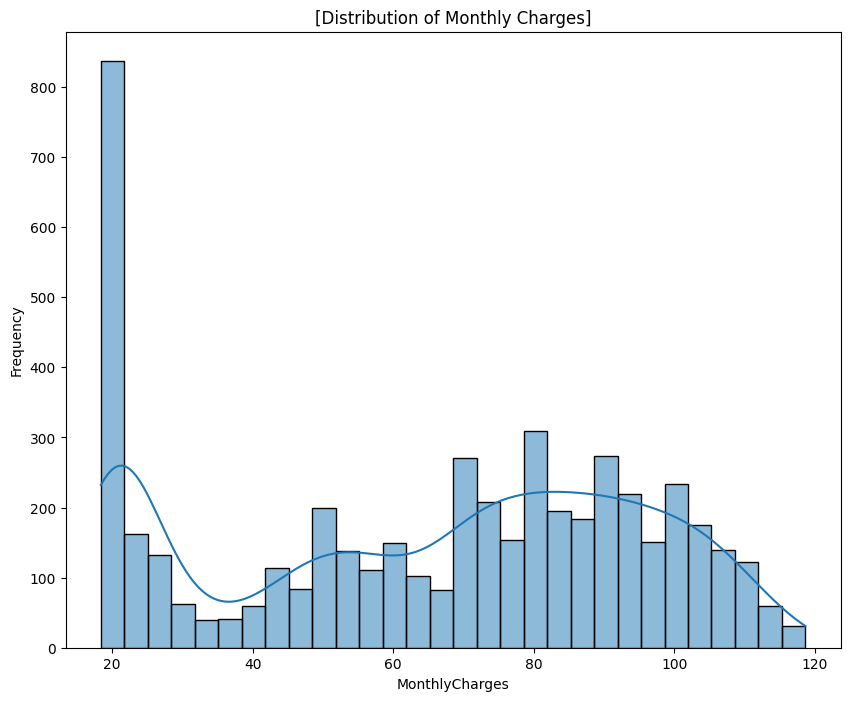

In [20]:
plt.figure(figsize=(10, 8))
sns.histplot(df['MonthlyCharges'], bins=30, kde=True)
plt.title('[Distribution of Monthly Charges]')
plt.xlabel('MonthlyCharges')
plt.ylabel('Frequency')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

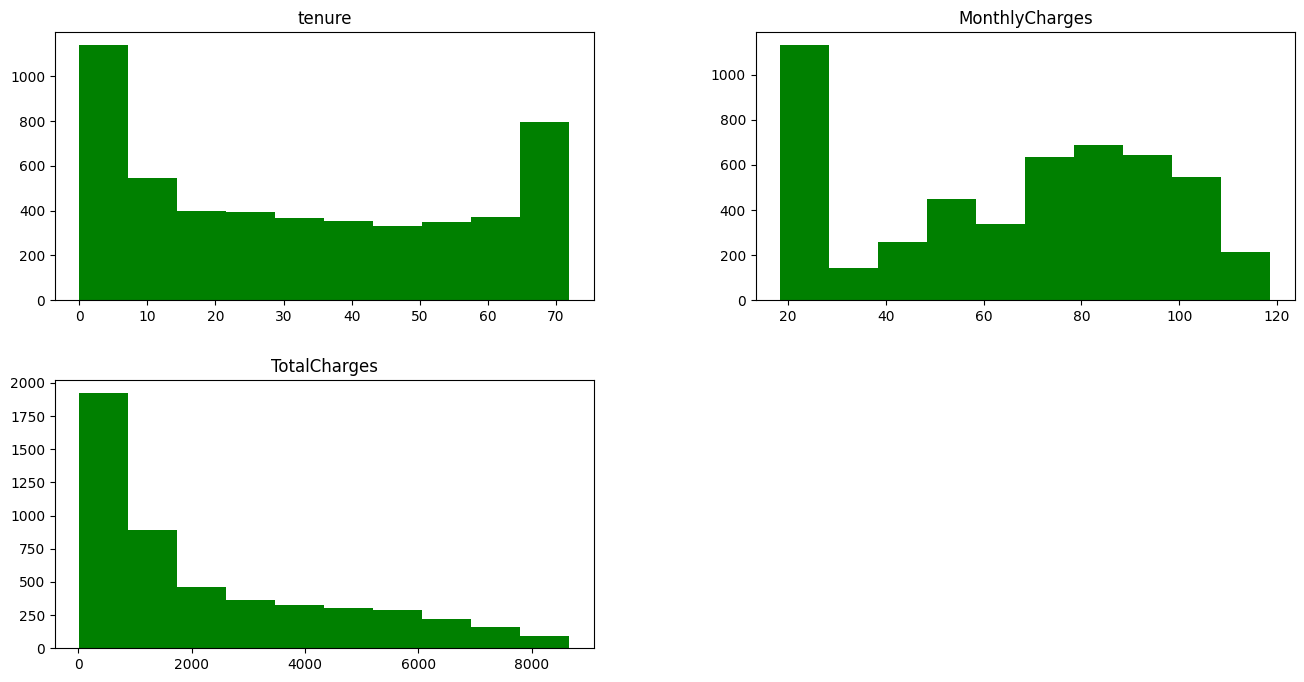

In [21]:
df.hist(figsize=(16,8), grid=False, color = 'green')
plt.show

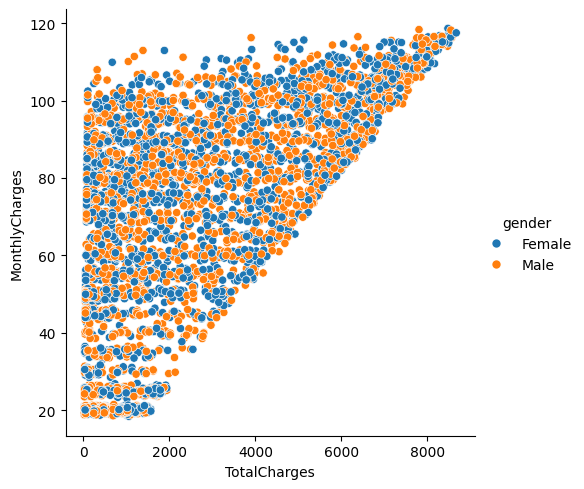

In [22]:

# Check and fix duplicate columns
if df.columns.duplicated().any():
    df = df.loc[:, ~df.columns.duplicated()]

# Check and fix duplicate indices
if df.index.duplicated().any():
    df = df.reset_index(drop=True)

sns.relplot(x='TotalCharges', y='MonthlyCharges', hue='gender', data=df)


In [23]:
correlation= df.corr(numeric_only= True)

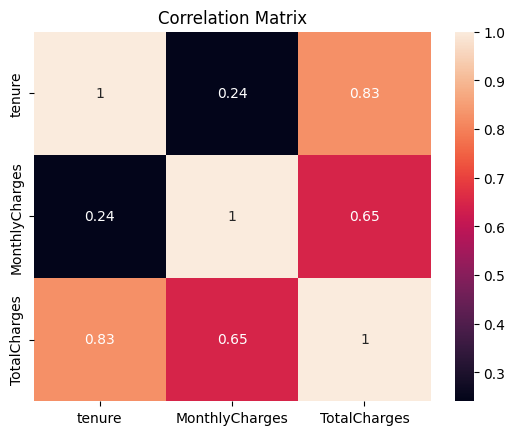

In [24]:
sns.heatmap(correlation, xticklabels= correlation.columns, yticklabels= correlation.columns, annot= True)
plt.title('Correlation Matrix')
plt.show()

<Figure size 1500x1000 with 0 Axes>

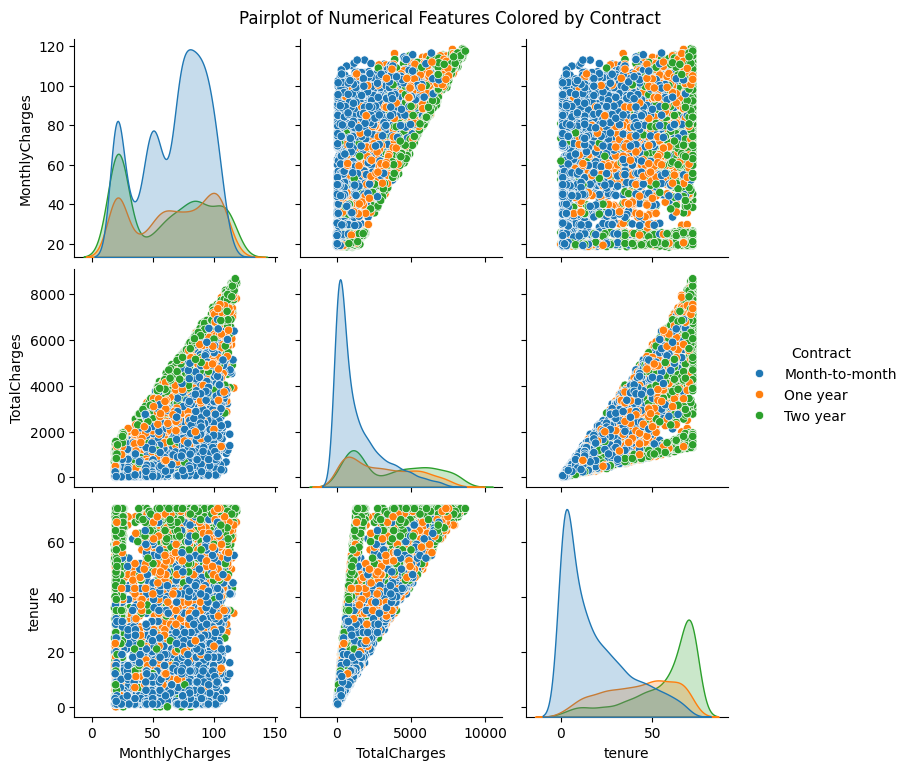

In [25]:
plt.figure(figsize=(15, 10))
sns.pairplot(df[['MonthlyCharges', 'TotalCharges', 'Contract', 'tenure']], hue='Contract')
plt.suptitle('Pairplot of Numerical Features Colored by Contract', y=1.02)
plt.show()

<Figure size 1500x1000 with 0 Axes>

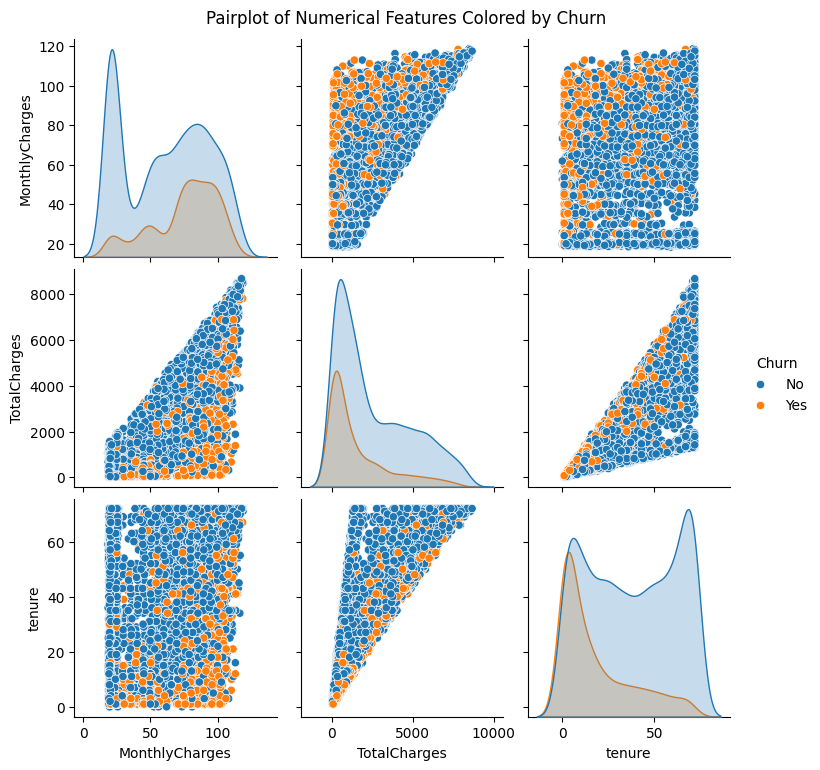

In [26]:
plt.figure(figsize=(15, 10))
sns.pairplot(df[['MonthlyCharges', 'TotalCharges', 'Churn', 'tenure']], hue='Churn')
plt.suptitle('Pairplot of Numerical Features Colored by Churn', y=1.02)
plt.show()

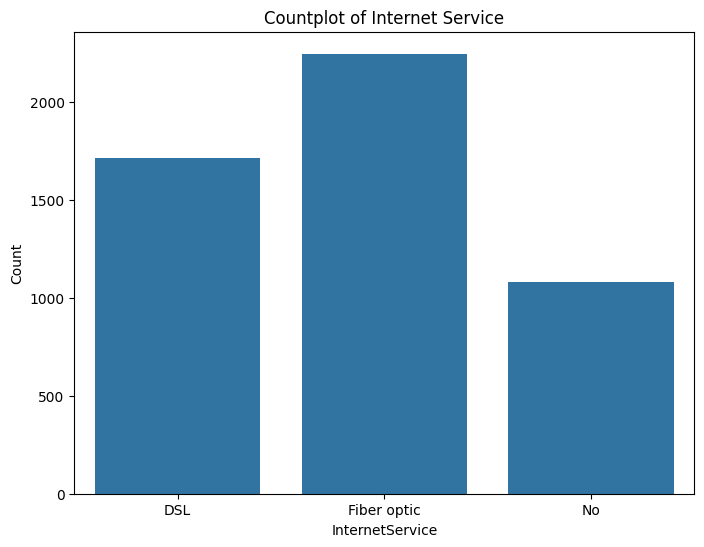

In [27]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='InternetService')

plt.title('Countplot of Internet Service')
plt.xlabel('InternetService')
plt.ylabel('Count')

plt.show()

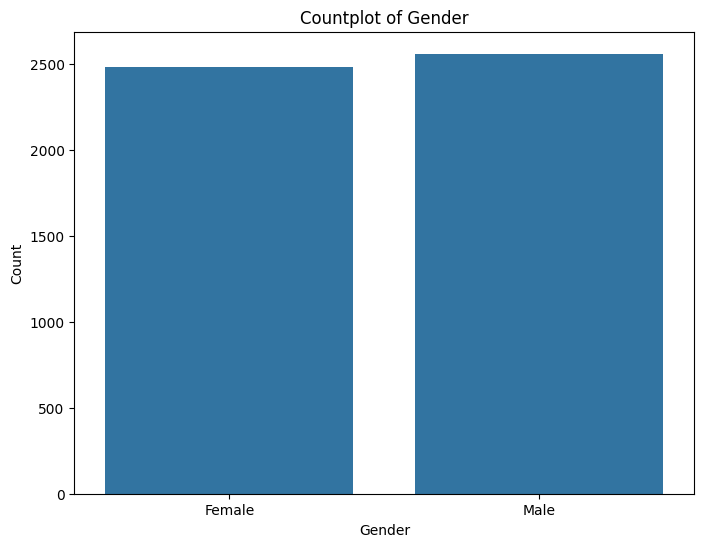

In [28]:

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='gender')

plt.title('Countplot of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.show()


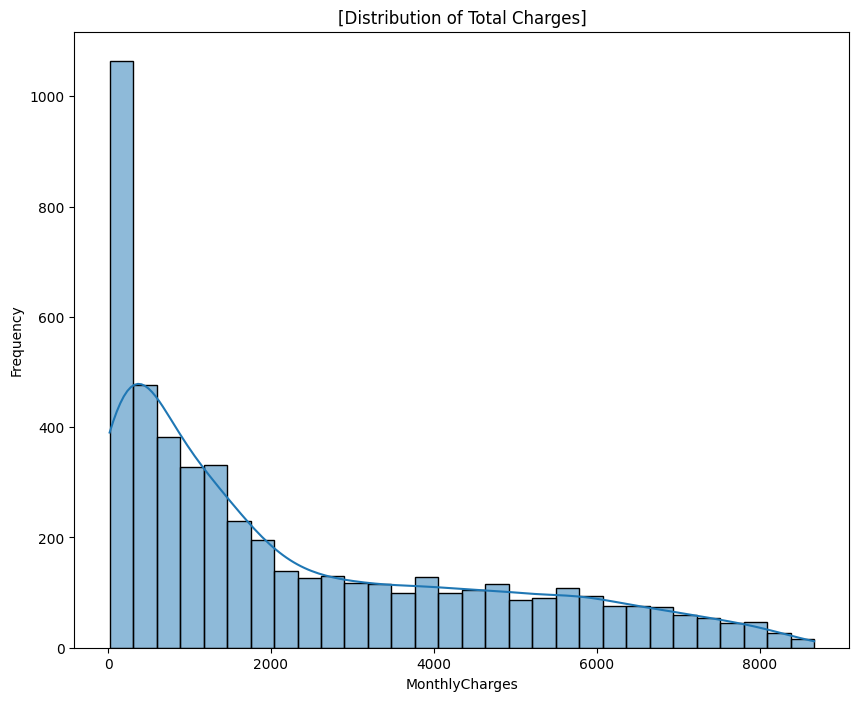

In [29]:
plt.figure(figsize=(10, 8))
sns.histplot(df['TotalCharges'], bins=30, kde=True)
plt.title('[Distribution of Total Charges]')
plt.xlabel('MonthlyCharges')
plt.ylabel('Frequency')
plt.show()

#### Key Insights
1. The boxplot provides a visual summary of the distribution of the tenure variable, highlighting the median, quartiles, and any potential outliers. 

2. The histogram with KDE overlay provides a detailed visualization of the MonthlyCharges distribution. The plot shows that a large number of customers are clustered around the lower end of the MonthlyCharges spectrum, specifically around $20. As the charges increase, the frequency of customers decreases and becomes more spread out, with a few peaks indicating common ranges. 

3. The bar plot indicates that there are almost equal numbers of male and female entries in the dataset, with males having a marginally higher count

4. The bar plot indicates that the total charges incurred by male customers are marginally higher than those incurred by female customers. The use of scientific notation on the Y-axis helps to accommodate the large values, making the plot clear and easy to understand



### HYPOTHESIS TESTING

In [30]:
from scipy.stats import chi2_contingency
# Create a contingency table
contingency_table = pd.crosstab(df['tenure'], df['Churn'])
print("Contingency Table:")
print(contingency_table)

# Perform the chi-square test for independence
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_val}")

# Interpret the result
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis: There is a significant association between tenure group and churn rate.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between tenure group and churn rate.")


Contingency Table:
Churn    No  Yes
tenure          
0         8    0
1       164  270
2        79   88
3        80   64
4        64   51
...     ...  ...
68       58    7
69       63    6
70       76   10
71      120    4
72      255    1

[73 rows x 2 columns]
Chi-Square Statistic: 774.1801118993867
P-value: 3.084245822214292e-118
Reject the null hypothesis: There is a significant association between tenure group and churn rate.


#### ANALYTICAL QUESTIONS

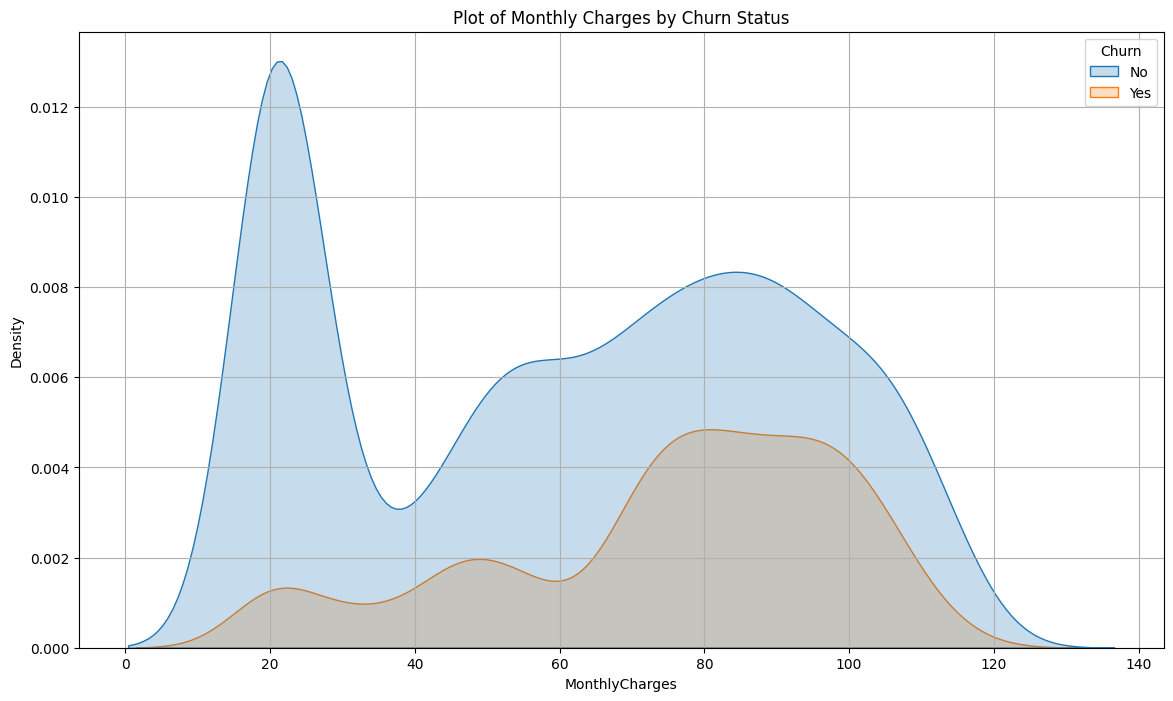

In [31]:
# Do customers with higher monthly charges exhibit different churn behaviors compared to those with lower charges?

plt.figure(figsize=(14, 8))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True)

plt.xlabel('MonthlyCharges')
plt.ylabel('Density')
plt.title('Plot of Monthly Charges by Churn Status')
plt.grid(True)
plt.show()


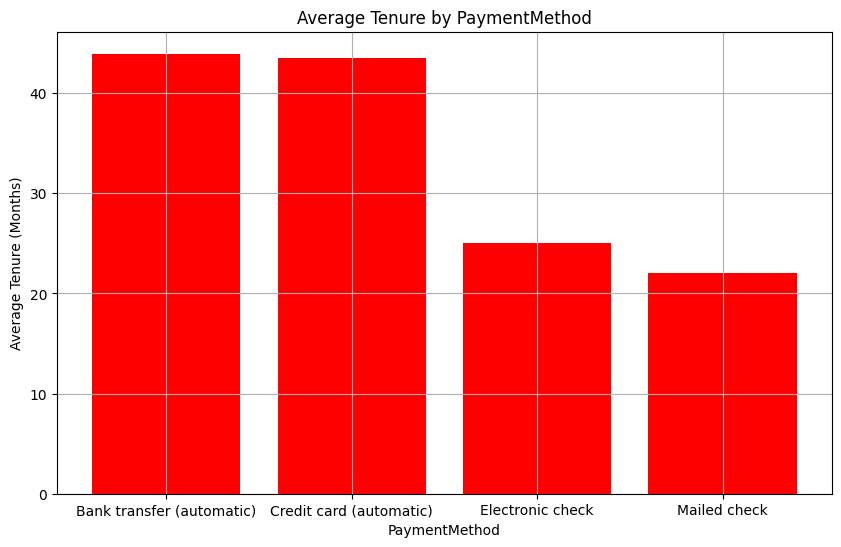

In [32]:
# Does payment method affect tenure for customers?
average_tenure = df.groupby('PaymentMethod')['tenure'].mean().reset_index()

# Plotting a bar plot
plt.figure(figsize=(10, 6))
plt.bar(average_tenure['PaymentMethod'], average_tenure['tenure'], color='red')
plt.xlabel('PaymentMethod')
plt.ylabel('Average Tenure (Months)')
plt.title('Average Tenure by PaymentMethod')
plt.grid(True)
plt.show()


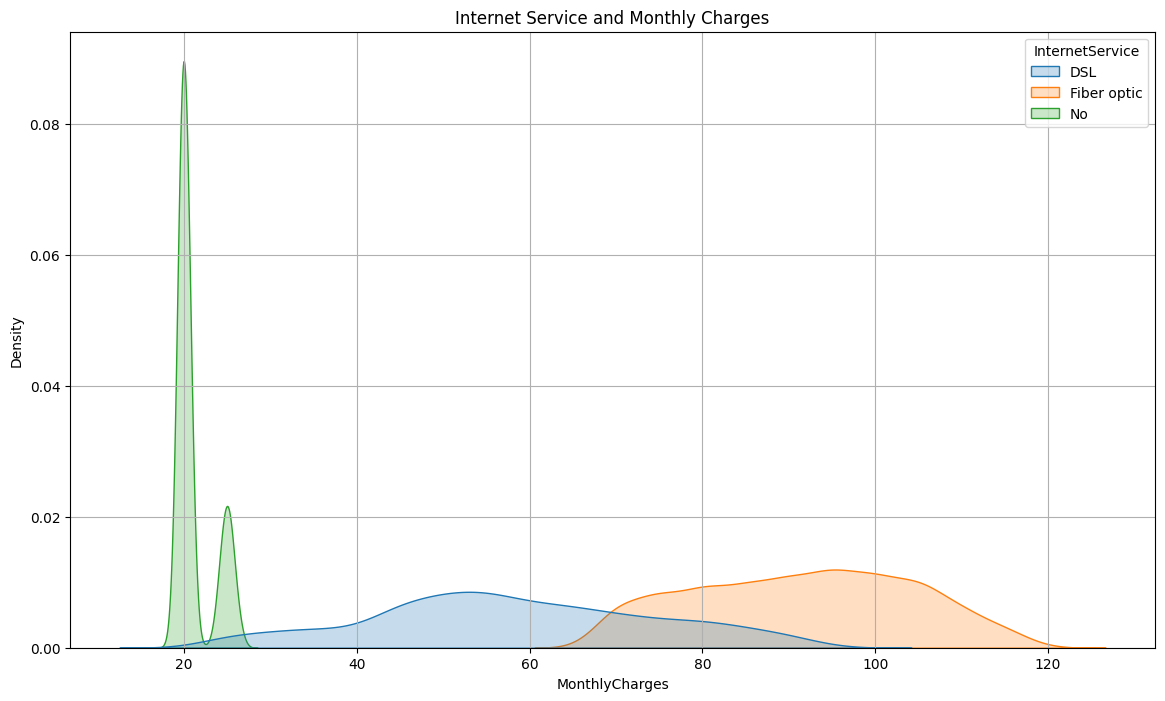

In [33]:
#  Which type of internetservices(DSL,Fiber optics) incur higher monthly charges?
plt.figure(figsize=(14, 8))
sns.kdeplot(data=df, x='MonthlyCharges', hue='InternetService', fill=True)

plt.xlabel('MonthlyCharges')
plt.ylabel('Density')
plt.title('Internet Service and Monthly Charges')
plt.grid(True)
plt.show()

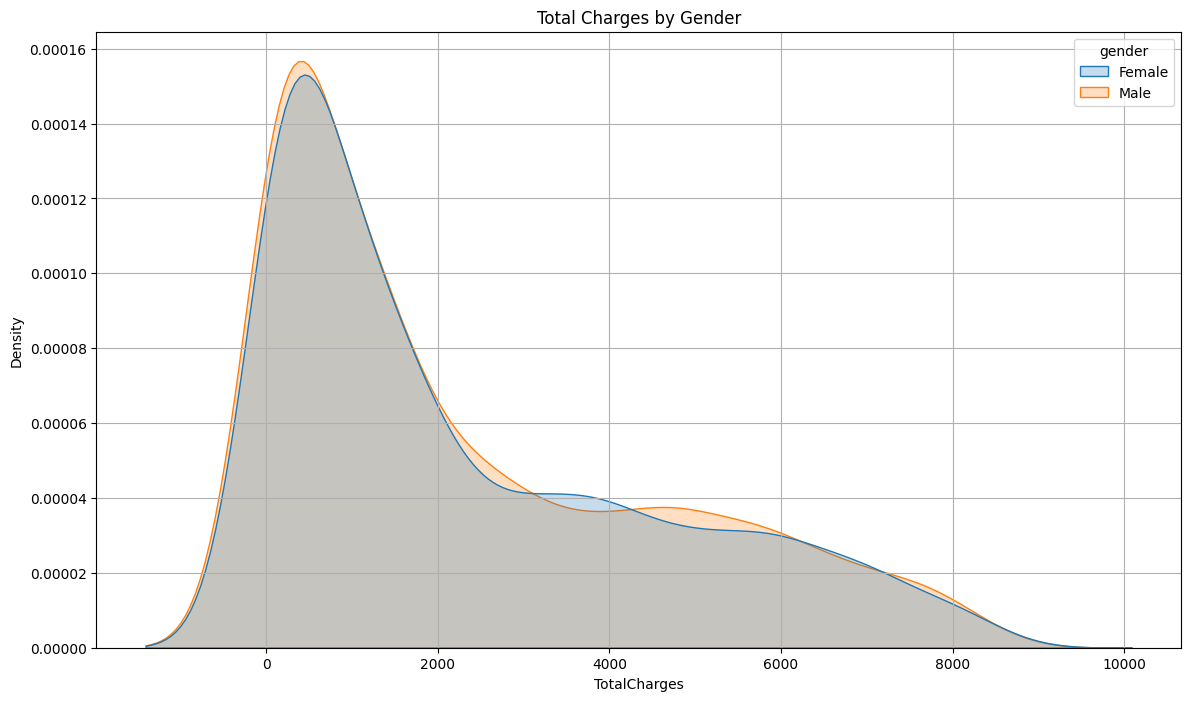

In [34]:
#4. What are the total charges by gender? Is there a significant difference between the total charges between males and females.
plt.figure(figsize=(14, 8))
sns.kdeplot(data=df, x='TotalCharges', hue='gender', fill=True)

plt.xlabel('TotalCharges')
plt.ylabel('Density')
plt.title('Total Charges by Gender')
plt.grid(True)
plt.show()

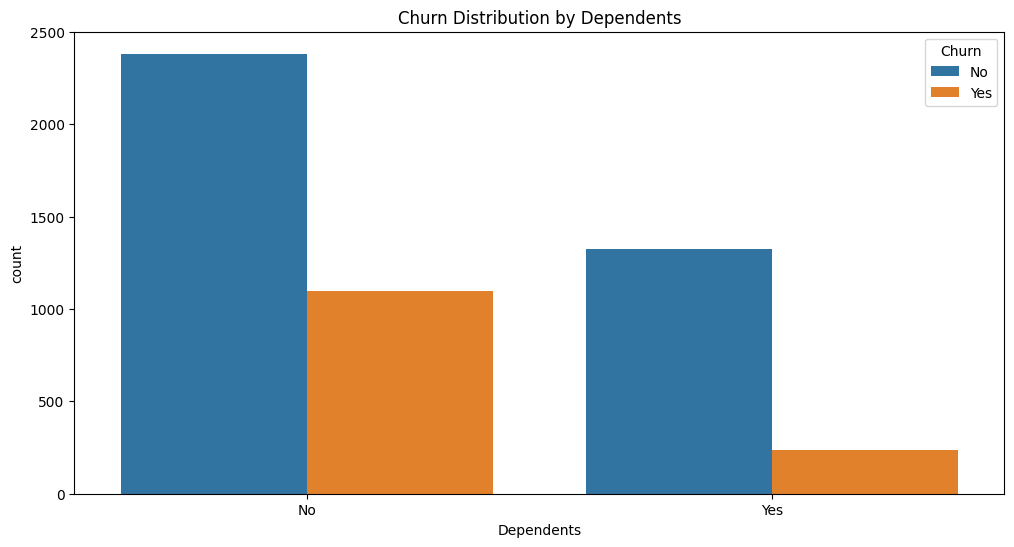

In [35]:
# Do dependents cause a rise in monthly charges prompting the possibility of customers churning?

# Count plot to see churn distribution by Dependents
plt.figure(figsize=(12, 6))
sns.countplot(x='Dependents', hue='Churn', data=df)
plt.title('Churn Distribution by Dependents')
plt.show()





## Data Preparation and Modelling


In [36]:
# Fill missing numerical values with the median of the column
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col].fillna(df[col].median(), inplace=True)

# Fill missing categorical values with the most frequent value of the column
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].value_counts().idxmax(), inplace=True)

In [37]:
# split for the dataset
X = df.drop(columns='Churn', axis=1)
y = df['Churn']
# Split the dataset into training and evaluation set
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Pipeline

Creating custom transformers for columns in the dataset

In [38]:
# Create a class to deal with dropping Customer ID from the dataset
class columnDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Drop the specified column
        return X.drop('customerID', axis=1)
    
    def get_feature_names_out(self, input_features=None):
        # If input_features is None or not provided, return None
        if input_features is None:
            return None
        # Return feature names after dropping the specified column
        return [feature for feature in input_features if feature != 'customerID']

# Create a class to deal with the inconsistencies in the totalCharges column and convert it into a float
class TotalCharges_cleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Replace empty string with NA
        X['TotalCharges'].replace(' ', np.nan, inplace=True)

        # Convert the values in the Totalcharges column to a float
        X['TotalCharges'] = X['TotalCharges'].transform(lambda x: float(x))
        return X
    # Since this transformer doesn't remove or alter features, return the input features
    def get_feature_names_out(self, input_features=None):
        return input_features

Create numerical, categorical, full pipeline, and label encoders for machine learning algorithm.

In [39]:
# Select the categorical and numerical columns in the dataset
num_columns = ['SeniorCitizen','tenure', 'MonthlyCharges', 'TotalCharges']
cat_columns = ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod']


# Create a categorical pipeline
cat_pipeline = Pipeline([
        ('column_dropper', columnDropper()),
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='No')),
        ('encoder', OneHotEncoder(sparse_output=False)),
])

# Create a numerical pipeline
num_pipeline = Pipeline([
        ('total_charges_cleaner', TotalCharges_cleaner()),
        ('imputer', SimpleImputer(missing_values=np.nan, strategy="mean")),
        ('pt_transform', PowerTransformer()),
        ('scaling', StandardScaler()),
])

# Create a full pipeline which contains the categorial and numerical pipeline
full_pipeline = ColumnTransformer([    
    ('num_pipeline', num_pipeline, num_columns),
    ('cat_pipeline', cat_pipeline, cat_columns),
])

# Encode the outcome column
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_eval_encoded = label_encoder.transform(y_eval)

## Random Classifier Pipeline

In [40]:
randomForest_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', RandomForestClassifier(random_state=0))
])

randomForest_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', RandomForestClassifier(random_state=0))])

In [41]:
# Get y predict values using random forest pipeline
rfc_y_pred = randomForest_pipeline.predict(X_eval)

# Get classification report for true and predicted values
rfc_report = classification_report(y_eval_encoded, rfc_y_pred)
print("Classification Report for Random Forest Pipeline:\n", rfc_report)

# Define model predictions for the model and true labels
rfc_pred_proba = randomForest_pipeline.predict_proba(X_eval)[:, 1]

# Calculate FPR and TPR for the model
rfc_fpr, rfc_tpr, _ = roc_curve(y_eval_encoded, rfc_pred_proba)

Classification Report for Random Forest Pipeline:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87       742
           1       0.66      0.49      0.56       267

    accuracy                           0.80      1009
   macro avg       0.75      0.70      0.72      1009
weighted avg       0.79      0.80      0.79      1009



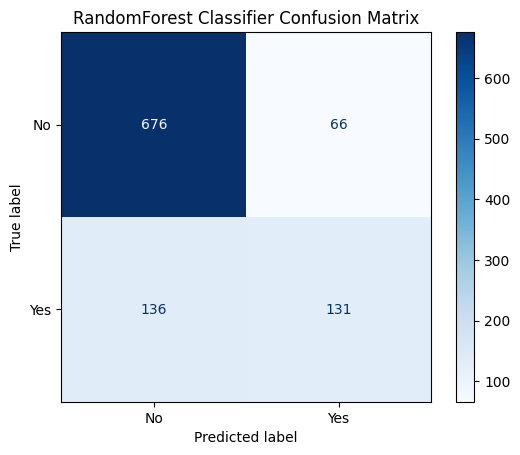

In [43]:
# Get confusion matrix values and display using confusion matrix display
rfc_cnf_matrix = confusion_matrix(y_eval_encoded, rfc_y_pred)
disp = ConfusionMatrixDisplay(rfc_cnf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('RandomForest Classifier Confusion Matrix');

## Decision Tree Pipeline

In [44]:
decisionTree_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', DecisionTreeClassifier(random_state=0))
])

decisionTree_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', DecisionTreeClassifier(random_state=0))])

In [45]:
# Get y predict values using decision tree pipeline
dtc_y_pred = decisionTree_pipeline.predict(X_eval)

# Get classification report for true and predicted values
dtc_report = classification_report(y_eval_encoded, dtc_y_pred)
print("Classification Report for Decision Tree Pipeline:\n", dtc_report)

# Define model predictions for the model and true labels
dtc_pred_proba = decisionTree_pipeline.predict_proba(X_eval)[:, 1]

# Calculate FPR and TPR for the model
dtc_fpr, dtc_tpr, _ = roc_curve(y_eval_encoded, dtc_pred_proba)



Classification Report for Decision Tree Pipeline:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       742
           1       0.53      0.48      0.50       267

    accuracy                           0.75      1009
   macro avg       0.67      0.66      0.67      1009
weighted avg       0.74      0.75      0.74      1009



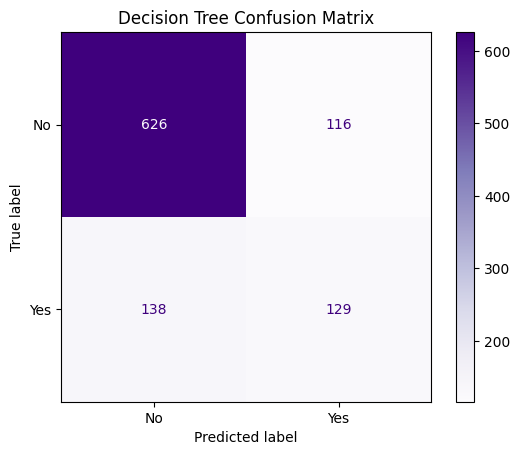

In [47]:
# Get confusion matrix values and display using confusion matrix display
dtc_cnf_matrix = confusion_matrix(y_eval_encoded, dtc_y_pred)
disp = ConfusionMatrixDisplay(dtc_cnf_matrix,display_labels=label_encoder.classes_)
disp.plot(cmap='Purples')
plt.title('Decision Tree Confusion Matrix');

## Gradient Boosting Classifier

In [48]:
gradientBoosting_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', GradientBoostingClassifier(random_state=0))
])

gradientBoosting_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', GradientBoostingClassifier(random_state=0))])

In [49]:
# Get y predict values using gradient boosting pipeline
gbc_y_pred = gradientBoosting_pipeline.predict(X_eval)

# Get classification report for true and predicted values
gbc_report = classification_report(y_eval_encoded, gbc_y_pred)
print("Classification Report for Gradient Boosting Pipeline:\n", gbc_report)

# Define model predictions for the model and true labels
gbc_pred_proba = gradientBoosting_pipeline.predict_proba(X_eval)[:, 1]

# Calculate FPR and TPR for the model
gbc_fpr, gbc_tpr, _ = roc_curve(y_eval_encoded, gbc_pred_proba)


Classification Report for Gradient Boosting Pipeline:
               precision    recall  f1-score   support

           0       0.83      0.92      0.88       742
           1       0.70      0.48      0.57       267

    accuracy                           0.81      1009
   macro avg       0.76      0.70      0.72      1009
weighted avg       0.80      0.81      0.79      1009



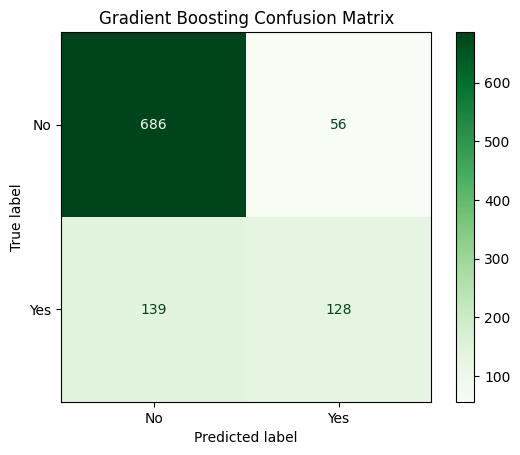

In [51]:
# Get confusion matrix values and display using confusion matrix display
gbc_cnf_matrix = confusion_matrix(y_eval_encoded, gbc_y_pred)
disp = ConfusionMatrixDisplay(gbc_cnf_matrix,display_labels=label_encoder.classes_)
disp.plot(cmap='Greens')
plt.title('Gradient Boosting Confusion Matrix');

## Support Vector Machine Pipeline

In [52]:
SVM_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', SVC(probability=True, random_state=0))
])

SVM_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', SVC(probability=True, random_state=0))])

In [53]:
# Get y predict values using svm pipeline
svm_y_pred = SVM_pipeline.predict(X_eval)

# Get classification report for true and predicted values
svm_report = classification_report(y_eval_encoded, svm_y_pred)
print("Classification Report for SVM Pipeline:\n", svm_report)

# Define model predictions for the model and true labels
svm_pred_proba = SVM_pipeline.predict_proba(X_eval)[:, 1]

# Calculate FPR and TPR for the model
svm_fpr, svm_tpr, _ = roc_curve(y_eval_encoded, svm_pred_proba)

Classification Report for SVM Pipeline:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88       742
           1       0.72      0.47      0.57       267

    accuracy                           0.81      1009
   macro avg       0.78      0.70      0.72      1009
weighted avg       0.80      0.81      0.80      1009



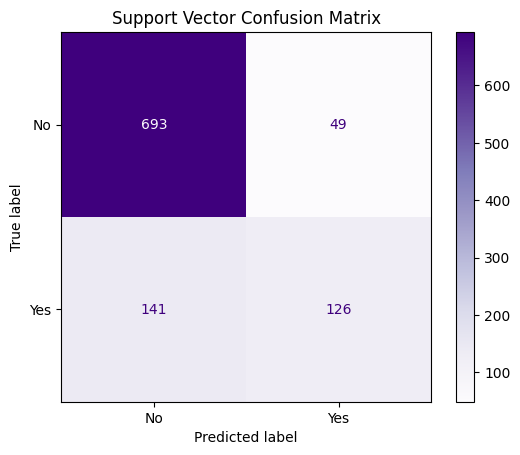

In [55]:
# Get confusion matrix values and display using confusion matrix display
svm_cnf_matrix = confusion_matrix(y_eval_encoded, svm_y_pred)
disp = ConfusionMatrixDisplay(svm_cnf_matrix,display_labels=label_encoder.classes_)
disp.plot(cmap='Purples')
plt.title('Support Vector Confusion Matrix');

### Key Insights
- The Random Classifier Model makes a total of 807 correct predictions while wrongly predicting 202 instances.
- The Decision Tree Model makes a total of 755 correct predictions while wrongly predicting 254 instances.
- The Gradient Boosting Matrix makes a total of 814 correct predictions while wrongly predicting 195 instances.
- The Support Vector Model makes a total of 819 correct predictions while wrongly predicting 190 instances.

## Model Evaluation and Interpretation

In [56]:
reports = [('RandomForest Classification:',rfc_report),
           ('DecisionTree Classification:',dtc_report),
           ('GradientBoosting Classification:',gbc_report),
           ('Support Vector Classification:',svm_report)
        ]

for label, report in reports:
    print(f'Report for {label}')
    print(report)
    print('_'*55)

Report for RandomForest Classification:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       742
           1       0.66      0.49      0.56       267

    accuracy                           0.80      1009
   macro avg       0.75      0.70      0.72      1009
weighted avg       0.79      0.80      0.79      1009

_______________________________________________________
Report for DecisionTree Classification:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       742
           1       0.53      0.48      0.50       267

    accuracy                           0.75      1009
   macro avg       0.67      0.66      0.67      1009
weighted avg       0.74      0.75      0.74      1009

_______________________________________________________
Report for GradientBoosting Classification:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88       742
 

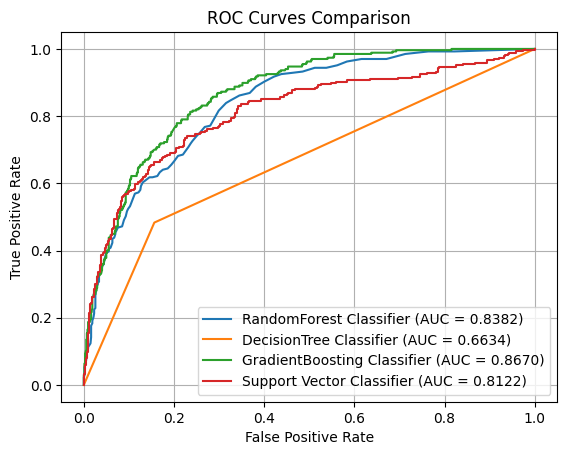

In [57]:
# Plot ROC curves
plt.plot(rfc_fpr, rfc_tpr, label=f'RandomForest Classifier (AUC = {rfc_auc_score:.4f})')
plt.plot(dtc_fpr, dtc_tpr, label=f'DecisionTree Classifier (AUC = {dtc_auc_score:.4f})')
plt.plot(gbc_fpr, gbc_tpr, label=f'GradientBoosting Classifier (AUC = {gbc_auc_score:.4f})')
plt.plot(svm_fpr, svm_tpr, label=f'Support Vector Classifier (AUC = {svm_auc_score:.4f})')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [58]:
# Put the name of the classifier and classifier into a list of tuples.
models = [
    ('RandomForest Classifier', RandomForestClassifier(random_state=0)),
    ('DecisionTree Classifier', DecisionTreeClassifier(random_state=0)),
    ('GradientBoosting Classifier', GradientBoostingClassifier(random_state=0)),
    ('SupportVector Classifier', SVC(probability=True, random_state=0))
]

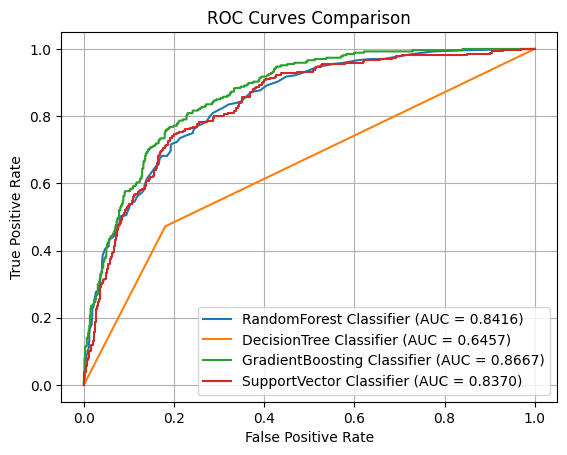

,Model,Accuracy,Precision,Recall,f1-score
0,RandomForest Classifier,0.796829,0.789830,0.796829,0.792347
1,DecisionTree Classifier,0.727453,0.725183,0.727453,0.726283
2,GradientBoosting Classifier,0.787909,0.820673,0.787909,0.796854
3,SupportVector Classifier,0.783944,0.810501,0.783944,0.792007


In [59]:
random_sampler = RandomOverSampler(random_state=0)

all_models = {}
random_sampler_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'f1-score'])


# Loop through the model and classifier in the models list
for model, classifier in models:
    # Perform preprocessing and fit the respective models
    model_pipeline = Pipeline([
        ('sampler', random_sampler),
        ('preprocessor', full_pipeline),
        ('classifier', classifier)
    ])
    all_models[model] = classifier

    model_pipeline.fit(X_train, y_train_encoded)
    # Predict values of the evaluation dataset
    y_pred = model_pipeline.predict(X_eval)

    random_sampler = RandomOverSampler(random_state=0)

all_models = {}
random_sampler_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'f1-score'])


# Loop through the model and classifier in the models list
for model, classifier in models:
    # Perform preprocessing and fit the respective models
    model_pipeline = Pipeline([
        ('sampler', random_sampler),
        ('preprocessor', full_pipeline),
        ('classifier', classifier)
    ])
    all_models[model] = classifier

    model_pipeline.fit(X_train, y_train_encoded)
    # Predict values of the evaluation dataset
    y_pred = model_pipeline.predict(X_eval)

    # Print accuracy, precision, recall, and f1-score for all the models
    random_sampler_dict = classification_report(y_eval_encoded, y_pred, output_dict=True)

    accuracy = random_sampler_dict['accuracy']
    precision = random_sampler_dict['weighted avg']['precision']
    recall = random_sampler_dict['weighted avg']['recall']
    f1_score = random_sampler_dict['weighted avg']['f1-score']

    random_sampler_df.loc[len(random_sampler_df)] = [model, accuracy, precision, recall, f1_score]

    # Define model predictions for the model and true labels
    pred_proba = model_pipeline.predict_proba(X_eval)[:,1]
    # Calculate FPR and TPR for the model
    fpr, tpr, threshold = roc_curve(y_eval_encoded, pred_proba)
    # Calculate AUC for the model
    auc_score = auc(fpr, tpr)

    # Plot ROC curves
    plt.plot(fpr, tpr, label=f'{model} (AUC = {auc_score:.4f})')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

random_sampler_df

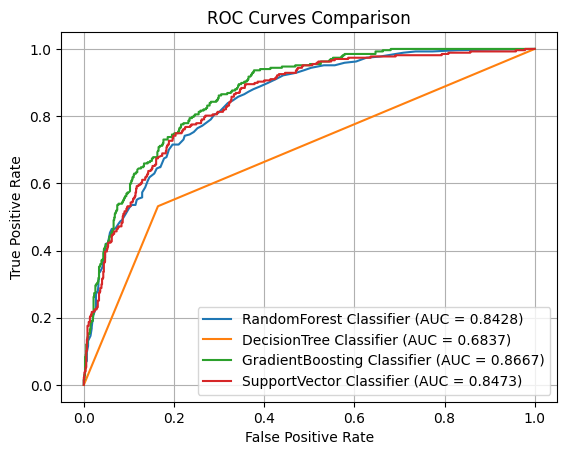

,Model,Accuracy,Precision,Recall,f1-score
0,RandomForest Classifier,0.795837,0.787251,0.795837,0.789933
1,DecisionTree Classifier,0.755203,0.754328,0.755203,0.754759
2,GradientBoosting Classifier,0.810704,0.812342,0.810704,0.811480
3,SupportVector Classifier,0.787909,0.802003,0.787909,0.793110


In [60]:
# Create instance of smote
smote_sampler = SMOTE(random_state=0)

smote_sampler_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'f1-score'])

# Loop through the classification models and fit them for all the models
for model, classifier in models:
    pipeline = Pipeline([
        ('preprocessor', full_pipeline),
        ('sampler', smote_sampler),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train_encoded)
    
    # Pred y values for the evaluate dataset
    y_pred = pipeline.predict(X_eval)

    # Print accuracy, precision, recall, and f1-score for all the models
    smote_sampler_dict = classification_report(y_eval_encoded, y_pred, output_dict=True)

    accuracy = smote_sampler_dict['accuracy']
    precision = smote_sampler_dict['weighted avg']['precision']
    recall = smote_sampler_dict['weighted avg']['recall']
    f1_score = smote_sampler_dict['weighted avg']['f1-score']

    smote_sampler_df.loc[len(smote_sampler_df)] = [model, accuracy, precision, recall, f1_score]
   # Define model predictions for the model and true labels
    pred_proba = pipeline.predict_proba(X_eval)[:,1]
    # Calculate FPR and TPR for the model
    fpr, tpr, threshold = roc_curve(y_eval_encoded, pred_proba)
    # Calculate AUC for the model
    auc_score = auc(fpr, tpr)

    # Plot ROC curves
    plt.plot(fpr, tpr, label=f'{model} (AUC = {auc_score:.4f})')
    
# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

smote_sampler_df

- SMOTE seems to outperform the Random Oversampler. The F1-score and AUC score are marginally higher than that from the Random Oversampler, therefore SMOTE is the sampling method we are choosing.

- The best performing models are The GradientBoosting Classifier and SVN classifier, with higher F1-scores and AUC scores as compared to the others.

## Feature Selection

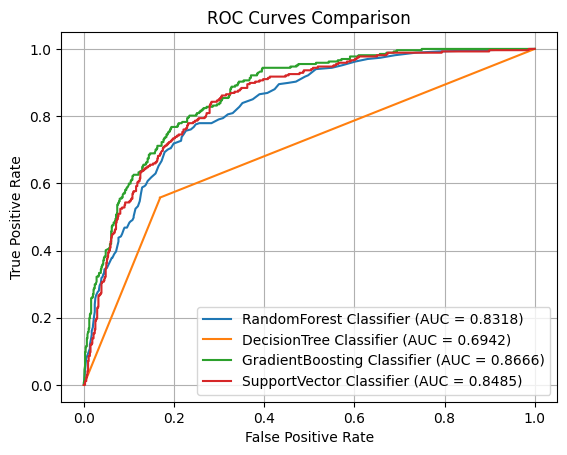

,Model,Accuracy,Precision,Recall,f1-score
0,RandomForest Classifier,0.787909,0.777768,0.787909,0.780758
1,DecisionTree Classifier,0.758176,0.759938,0.758176,0.759029
2,GradientBoosting Classifier,0.807730,0.811150,0.807730,0.809271
3,SupportVector Classifier,0.790882,0.807208,0.790882,0.796621


In [61]:
best_feature_selectors = SelectKBest(score_func=partial(mutual_info_classif, random_state=0),k=25)

feature_selected_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'f1-score'])

for model, classifier in models:
    pipeline = Pipeline([
        ('preprocessor', full_pipeline),
        ('sampler', smote_sampler),
        ('feature_selection', best_feature_selectors),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train_encoded)
    
    y_pred = pipeline.predict(X_eval)

    # Print accuracy, precision, recall, and f1-score for all the models
    feature_selected_dict = classification_report(y_eval_encoded, y_pred, output_dict=True)

    accuracy = feature_selected_dict['accuracy']
    precision = feature_selected_dict['weighted avg']['precision']
    recall = feature_selected_dict['weighted avg']['recall']
    f1_score = feature_selected_dict['weighted avg']['f1-score']

    feature_selected_df.loc[len(feature_selected_df)] = [model, accuracy, precision, recall, f1_score]
   # Define model predictions for the model and true labels
    pred_proba = pipeline.predict_proba(X_eval)[:,1]
    # Calculate FPR and TPR for the model
    fpr, tpr, threshold = roc_curve(y_eval_encoded, pred_proba)
    # Calculate AUC for the model
    auc_score = auc(fpr, tpr)

    # Plot ROC curves
    plt.plot(fpr, tpr, label=f'{model} (AUC = {auc_score:.4f})')
    
# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

feature_selected_df

There is a significant change in the values of the f1-score for all the models.  The performance of the GradientBoosting classifier has been consistent with its performance on both balanced and imbalanced datasets and will be selected for our prediction model. 

## Hyperparameter Tuning

### Gradient Boosting Classifier

In [62]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': randint(1, 200),
    'classifier__max_features': randint(1, 50),
    'classifier__max_depth': randint(1, 20),
    'classifier__learning_rate': uniform(0.01, 0.5)
}

In [78]:
gb_classifier = all_models['GradientBoosting Classifier']
# Create the GradientBoostingClassifier
gb_classifier_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('smote', smote_sampler),
    ('feature_selection', best_feature_selectors),
    ('classifier', gb_classifier)
    ])

# Define model predictions for the model and true labels
pred_proba = gb_classifier_pipeline.predict_proba(X_eval)[:,1]
# Calculate FPR and TPR for the model
fpr, tpr, threshold = roc_curve(y_eval_encoded, pred_proba)
# Calculate AUC for the model
auc_score = auc(fpr, tpr)

# Create RandomizedSearchCV instance
random_search = RandomizedSearchCV(gb_classifier_pipeline, param_distributions=param_dist, n_iter=50, cv=5, random_state=0, verbose=2, n_jobs=-1)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('total_charges_cleaner',
                                                                                                TotalCharges_cleaner()),
                                                                                               ('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('pt_transform',
                                                                                                PowerTransformer()),
                                                                                               ('scaling',
                                                                                                StandardScaler())]),
                                                                               ['SeniorCitizen',
                                                                                'tenure',
                                                                                'MonthlyCharges',
                                                                                'TotalCharges']),
                                                                              ('cat_pipeline',...
                   param_distributions={'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023E3F47D4E0>,
                                        'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023E3F5122C0>,
                                        'classifier__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023E3C354C40>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023E3F512470>},
                   random_state=0, verbose=2)

In [64]:
pd.DataFrame(zip(fpr, tpr, threshold),columns=['False positive', 'True positive', 'Threshold']).tail(115)

,False positive,True positive,Threshold
225,0.326146,0.880150,0.237625
226,0.326146,0.883895,0.237391
227,0.327493,0.883895,0.235981
228,0.327493,0.887640,0.234887
229,0.335580,0.887640,0.228527
...,...,...,...
335,0.969003,1.000000,0.014346
336,0.971698,1.000000,0.014337
337,0.989218,1.000000,0.012391
338,0.997305,1.000000,0.012364


In [79]:
best_parameters = random_search.best_params_
best_parameters

{'classifier__learning_rate': 0.33983420603470643,
 'classifier__max_depth': 2,
 'classifier__max_features': 41,
 'classifier__n_estimators': 161}

In [80]:
gb_classifier_pipeline.set_params(**best_parameters)
gb_classifier_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('smote', SMOTE(random_state=0)),
                ('feature_selection',
                 SelectKBest(k=25,
                             score_func=functools.partial(<function mutual_info_classif at 0x0000023E308D6440>, random_state=0))),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.33983420603470643,
                                            max_depth=2, max_features=41,
                                            n_estimators=161,
                                            random_state=0))])

In [81]:
gb_classifier_pipeline.set_params(**best_parameters)
gb_classifier_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('smote', SMOTE(random_state=0)),
                ('feature_selection',
                 SelectKBest(k=25,
                             score_func=functools.partial(<function mutual_info_classif at 0x0000023E308D6440>, random_state=0))),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.33983420603470643,
                                            max_depth=2, max_features=41,
                                            n_estimators=161,
                                            random_state=0))])

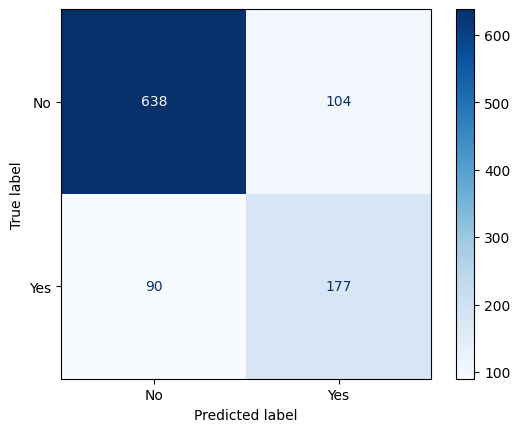

In [67]:
predic = gb_classifier_pipeline.predict(X_eval)
conf = confusion_matrix(y_eval_encoded, predic)

ConfusionMatrixDisplay(conf, display_labels=label_encoder.classes_).plot(cmap='Blues');

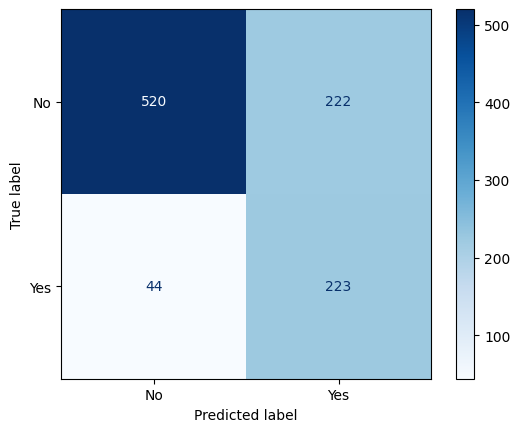

In [68]:
threshold_ = 0.276767

y_predic_proba = gb_classifier_pipeline.predict_proba(X_eval)[:,1]

binary_classification = (y_predic_proba >= threshold_)

threshold_matrix = confusion_matrix(y_eval_encoded, binary_classification)
ConfusionMatrixDisplay(threshold_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues');

### Support Vector Classifier

In [69]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'classifier__C': [1, 5, 10],
    'classifier__gamma': [0.1, 1, 'auto'],
    'classifier__degree': [1,2,3]
}

In [70]:
sv_classifier = all_models['SupportVector Classifier']
# Create the GradientBoostingClassifier
sv_classifier_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('smote', smote_sampler),
    ('feature_selection', best_feature_selectors),
    ('classifier', sv_classifier)
    ])

# Define model predictions for the model and true labels
pred_proba = sv_classifier_pipeline.predict_proba(X_eval)[:,1]
# Calculate FPR and TPR for the model
fpr, tpr, threshold = roc_curve(y_eval_encoded, pred_proba)
# Calculate AUC for the model
auc_score = auc(fpr, tpr)



In [71]:
# Create GridSearchCV instance
grid_search = GridSearchCV(sv_classifier_pipeline, param_grid=param_grid, verbose=2)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=0.1; total time=  25.3s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=0.1; total time=  30.2s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=0.1; total time=  25.3s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=0.1; total time=  26.4s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=0.1; total time=  33.1s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=1; total time=  40.8s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=1; total time=  47.6s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=1; total time=  41.8s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=1; total time=  39.6s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=1; total time=  48.5s
[CV] END classifier__C=1, classifier__degree=1, 

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('total_charges_cleaner',
                                                                                          TotalCharges_cleaner()),
                                                                                         ('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('pt_transform',
                                                                                          PowerTransformer()),
                                                                                         ('scaling',
                                                                                          StandardScaler())]),
                                                                         ['SeniorCitizen',
                                                                          'tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(st...
                                                                          'PaymentMethod'])])),
                                       ('smote', SMOTE(random_state=0)),
                                       ('feature_selection',
                                        SelectKBest(k=25,
                                                    score_func=functools.partial(<function mutual_info_classif at 0x0000023E308D6440>, random_state=0))),
                                       ('classifier',
                                        SVC(probability=True,
                                            random_state=0))]),
             param_grid={'classifier__C': [1, 5, 10],
                         'classifier__degree': [1, 2, 3],
                         'classifier__gamma': [0.1, 1, 'auto']},
             verbose=2)

In [72]:
pd.DataFrame(zip(fpr, tpr, threshold),columns=['False positive', 'True positive', 'Threshold']).tail(70)

,False positive,True positive,Threshold
220,0.315364,0.865169,0.197060
221,0.324798,0.865169,0.192371
222,0.324798,0.868914,0.190789
223,0.334232,0.868914,0.185858
224,0.334232,0.872659,0.185720
...,...,...,...
285,0.898922,0.992509,0.060803
286,0.898922,0.996255,0.060664
287,0.986523,0.996255,0.036360
288,0.986523,1.000000,0.035743


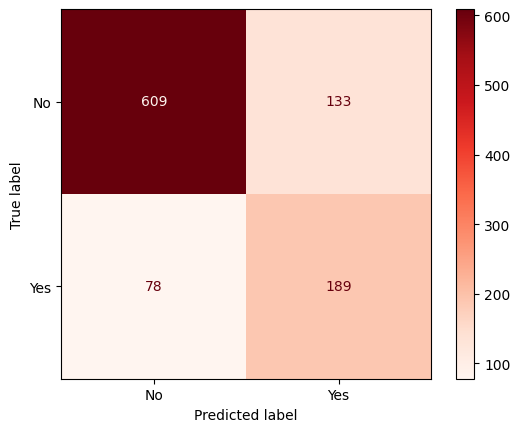

In [73]:
predic = sv_classifier_pipeline.predict(X_eval)
conf = confusion_matrix(y_eval_encoded, predic)

ConfusionMatrixDisplay(conf, display_labels=label_encoder.classes_).plot(cmap='Reds');

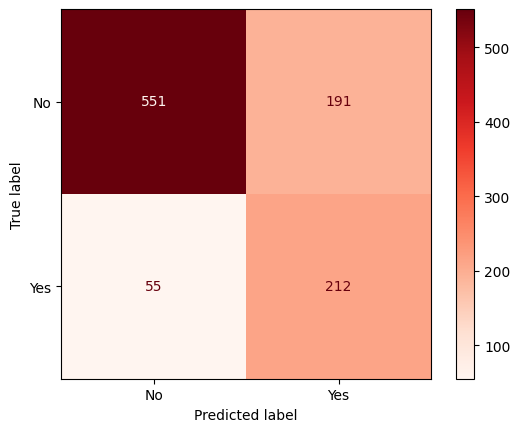

In [74]:
threshold_ = 0.253424

y_predic_proba = sv_classifier_pipeline.predict_proba(X_eval)[:,1]

binary_classification = (y_predic_proba >= threshold_)

threshold_matrix = confusion_matrix(y_eval_encoded, binary_classification)
ConfusionMatrixDisplay(threshold_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds');

## Model Persistence

In [86]:
# Define the directory where the models will be saved
model_dir = '../model/'

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the models
joblib.dump(gb_classifier_pipeline, os.path.join(model_dir, 'GradientBoosting.joblib'))
joblib.dump(sv_classifier_pipeline, os.path.join(model_dir, 'SupportVector.joblib'))
joblib.dump(label_encoder, os.path.join(model_dir, 'label_encoder.joblib'))

['../model/label_encoder.joblib']